In [255]:
#Inspired by http://tullo.ch/articles/svm-py/
# Training: Calculate lag_range_multipliers (weights) and bias
# Inference use Sum of (Kernel(x_train, xi) * weights * targets)
import numpy as np
import cvxopt.solvers

MIN_SUPPORT_VECTOR_MULTIPLIER = 1e-5


class SVMClassifier(object):
    
    def __init__(self, kernel, c):
        self._kernel = kernel
        self._c = c
        
    def predict(self, x, bias=None):
        """
        Computes the SVM prediction on the given features x.
        """
        if bias is None:
            result = self._bias
        else:
            result = bias
            
        for z_i, x_i, y_i in zip(self._weights,
                                 self._support_vectors,
                                 self._support_vector_labels):
            result += z_i * y_i * self._kernel(x_i, x)
        return np.sign(result).item()
    

    def fit(self, X, y):
        """Given the training features X with labels y, returns a SVM
        predictor representing the trained SVM.
        """
        lagrange_multipliers = self._compute_multipliers(X, y)
        
        support_vector_indices = \
            lagrange_multipliers > MIN_SUPPORT_VECTOR_MULTIPLIER

        self._weights = lagrange_multipliers[support_vector_indices]
        self._support_vectors = X[support_vector_indices]
        self._support_vector_labels = y[support_vector_indices]

        # http://www.cs.cmu.edu/~guestrin/Class/10701-S07/Slides/kernels.pdf
        # bias = y_k - \sum z_i y_i  K(x_k, x_i)
        # Thus we can just predict an example with bias of zero, and
        # compute error.
        self._bias = np.mean(
            [y_k - self.predict(x_k, bias=0.0)
             for (y_k, x_k) in zip(self._support_vector_labels, self._support_vectors)])
 
    def _gram_matrix(self, X):
        n_samples, n_features = X.shape
        K = np.zeros((n_samples, n_samples))
        # TODO(tulloch) - vectorize
        for i, x_i in enumerate(X):
            for j, x_j in enumerate(X):
                K[i, j] = self._kernel(x_i, x_j)
        return K

    def _compute_multipliers(self, X, y):
        n_samples, n_features = X.shape

        K = self._gram_matrix(X)
        # Solves
        # min 1/2 x^T P x + q^T x
        # s.t.
        #  Gx \coneleq h
        #  Ax = b

        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(-1 * np.ones(n_samples))

        # -a_i \leq 0
        # TODO(tulloch) - modify G, h so that we have a soft-margin classifier
        G_std = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        h_std = cvxopt.matrix(np.zeros(n_samples))

        # a_i \leq c
        G_slack = cvxopt.matrix(np.diag(np.ones(n_samples)))
        h_slack = cvxopt.matrix(np.ones(n_samples) * self._c)

        G = cvxopt.matrix(np.vstack((G_std, G_slack)))
        h = cvxopt.matrix(np.vstack((h_std, h_slack)))

        A = cvxopt.matrix(y, (1, n_samples))
        b = cvxopt.matrix(0.0)

        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        return np.ravel(solution['x'])

# Test as original author


In [256]:
#!/usr/bin/env python

import numpy as np
import matplotlib.pyplot as plt

num_samples=10
num_features=2
X = np.matrix(np.random.normal(size=num_samples * num_features)
                    .reshape(num_samples, num_features))
Y = 2 * (X.sum(axis=1) > 0) - 1.0

kernel = Kernel.linear()
c = 0.1#?
svm = SVMClassifier(kernel, c)
svm.fit(X, Y)

     pcost       dcost       gap    pres   dres
 0: -2.1565e+00 -1.8237e+00  5e+01  7e+00  2e-16
 1: -4.3613e-01 -1.6954e+00  2e+00  2e-01  4e-16
 2: -3.5138e-01 -5.9621e-01  2e-01  7e-17  3e-16
 3: -3.7214e-01 -4.0739e-01  4e-02  4e-17  3e-16
 4: -3.8502e-01 -3.9016e-01  5e-03  4e-17  9e-17
 5: -3.8816e-01 -3.8828e-01  1e-04  6e-17  2e-16
 6: -3.8824e-01 -3.8824e-01  1e-06  6e-17  1e-16
 7: -3.8824e-01 -3.8824e-01  1e-08  4e-17  1e-16
Optimal solution found.


In [257]:
X.shape, Y.shape

((10, 2), (10, 1))

In [258]:
X[0], Y[0]

(matrix([[ 0.5018723 ,  0.13884618]]), matrix([[ 1.]]))

## Draw boundaries

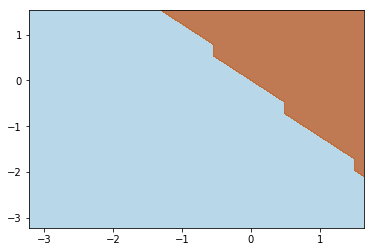

In [259]:
import matplotlib.cm as cm
import itertools

grid_size=20
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                     np.linspace(y_min, y_max, grid_size),
                     indexing='ij')
flatten = lambda m: np.array(m).reshape(-1,)
result = []
for (i, j) in itertools.product(range(grid_size), range(grid_size)):
    point = np.array([xx[i, j], yy[i, j]]).reshape(1, 2)
    result.append(svm.predict(point))

Z = np.array(result).reshape(xx.shape)

plt.contourf(xx, yy, Z,
             cmap=cm.Paired,
             levels=[-0.001, 0.001],
             extend='both',
             alpha=0.8)

## Draw predictions

In [260]:
pred = []
for x in X:
    pred.append(svm.predict(x.reshape(1,2))) 

In [261]:
pred[0],Y[0]

(1.0, matrix([[ 1.]]))

In [262]:
Y = Y.reshape(len(Y))

In [263]:
print('Accuracy from scratch: {}'.format((pred == Y).sum().astype(float) / len(pred)))

Accuracy from scratch: 1.0


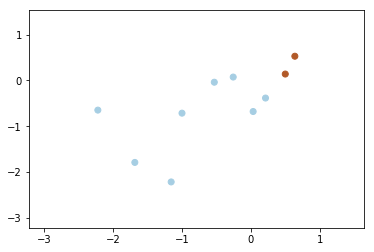

In [264]:
plt.scatter(flatten(X[:, 0]), flatten(X[:, 1]),
            c=flatten(Y), cmap=cm.Paired)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

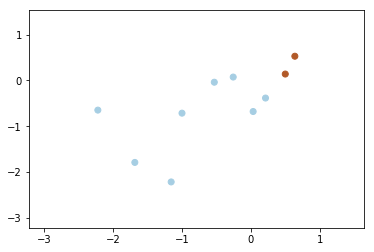

In [265]:
plt.scatter(flatten(X[:, 0]), flatten(X[:, 1]),
            c=flatten(pred), cmap=cm.Paired)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

# Simulated features as used in logistic regression

In [282]:
import numpy as np
np.random.seed(12)
num_observations =500

x1 = np.random.multivariate_normal([0, 0], [[1, .75],[.75, 1]], num_observations)
x2 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)

X2 = np.vstack((x1, x2)).astype(np.float32)
Y2 = np.hstack((np.zeros(num_observations),
                              np.ones(num_observations)))

In [283]:
X.shape, X2.shape

((10, 2), (1000, 2))

In [284]:
Y.shape, Y2.shape

((1, 10), (1000,))

In [285]:
X2 = np.asmatrix(X2)

In [286]:
Y2 = np.asmatrix(Y2.reshape(len(Y2),1))

In [287]:
X.shape, X2.shape

((10, 2), (1000, 2))

In [288]:
Y.shape, Y2.shape

((1, 10), (1000, 1))

In [289]:
X[0], X2[0]

(matrix([[ 0.5018723 ,  0.13884618]]),
 matrix([[-0.2015173 , -0.68335819]], dtype=float32))

In [290]:
Y[0],Y2[0]

(matrix([[ 1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.]]), matrix([[ 0.]]))

In [291]:
from kernel import Kernel
kernel = Kernel.linear()
c = 0.1#?
svm = SVMClassifier(kernel, c)
svm.fit(X2, Y2)

     pcost       dcost       gap    pres   dres
 0: -2.7500e+02 -1.7250e+02  4e+03  2e+01  2e-16
 1: -4.2503e+01 -1.5965e+02  2e+02  2e-01  2e-16
 2: -4.6087e+01 -5.4177e+01  9e+00  9e-03  3e-16
 3: -4.9961e+01 -5.0048e+01  1e-01  9e-05  3e-16
 4: -5.0000e+01 -5.0000e+01  1e-03  9e-07  2e-16
 5: -5.0000e+01 -5.0000e+01  1e-05  9e-09  2e-16
Optimal solution found.


In [292]:
pred = []
for x in X2:
    pred.append(svm.predict(x.reshape(1,2))) 

In [293]:
pred

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [294]:
print('Accuracy from scratch: {}'.format((preds == simulated_labels).sum().astype(float) / len(preds)))

Accuracy from scratch: 0.5


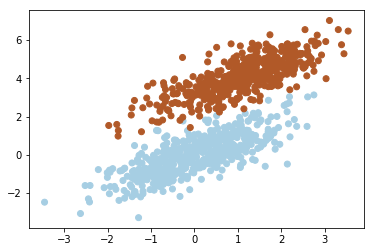

In [295]:
plt.scatter(flatten(X2[:, 0]), flatten(X2[:, 1]),
            c=flatten(Y2), cmap=cm.Paired)
plt.show()

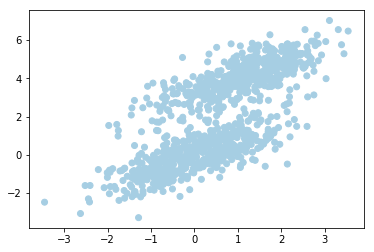

In [296]:
plt.scatter(flatten(X2[:, 0]), flatten(X2[:, 1]),
            c=flatten(pred), cmap=cm.Paired)
plt.show()